## Imports

I am starting with standard data science libraries: `numpy`, `pandas`, `sklearn`, `matplotlib`.

In [254]:
import numpy as np
import pandas as pd
# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
import os
import warnings
warnings.filterwarnings('ignore')
# plots
import matplotlib.pyplot as plt
import seaborn as sns

## Read Data


In [255]:
app_train = pd.read_csv('data/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (2353, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


307511 loans events with 122 features (variables) including the `TARGET`, which we want predict.

In [256]:
app_test = pd.read_csv('data/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (2352, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In the test set is missing a `TARGET` column.

# Exploratory Data Analysis

## The Distribution of the Target

The target is either a 0 when the loan was repaid on time, or a 1, when the client had payment difficulties.

In [257]:
app_train['TARGET'].value_counts()

TARGET
0    2184
1     169
Name: count, dtype: int64

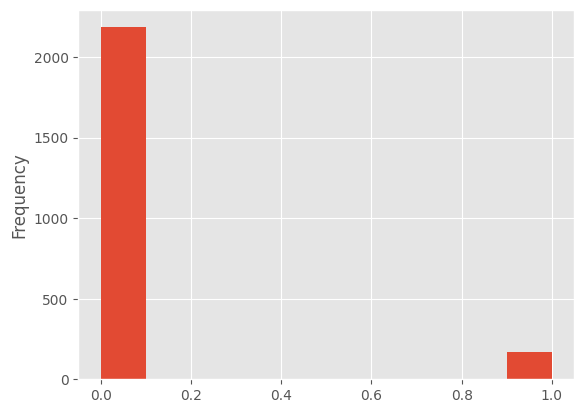

In [258]:
app_train['TARGET'].astype(int).plot.hist();

We see an imbalanced class problem. There are far more loans that were repaid on time than loans that were not repaid.

## Missing Values

In [259]:
def missing_values_table(df):
        # Total
        mis_val = df.isnull().sum()
        # Percentage
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        # Table
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        # Sorting
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [260]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Dataframe has 122 columns.
There are 85 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MODE,1628,69.2
COMMONAREA_MEDI,1628,69.2
COMMONAREA_AVG,1628,69.2
NONLIVINGAPARTMENTS_MODE,1619,68.8
NONLIVINGAPARTMENTS_AVG,1619,68.8
NONLIVINGAPARTMENTS_MEDI,1619,68.8
LIVINGAPARTMENTS_MODE,1597,67.9
LIVINGAPARTMENTS_AVG,1597,67.9
LIVINGAPARTMENTS_MEDI,1597,67.9
FONDKAPREMONT_MODE,1581,67.2


## Columns

Number of columns of each data type. `int64`, `float64` and `object`.

In [261]:
app_train.dtypes.value_counts()

float64    85
int64      21
object     16
Name: count, dtype: int64

In [262]:
# Unique classes
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               5
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             57
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

## Encoding Categorical Variables


In [263]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])

            # Keep track of how many columns were label encoded
            le_count += 1

print('%d columns were label encoded.' % le_count)

4 columns were label encoded.


In [264]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (2353, 236)
Testing Features shape:  (2352, 231)


### Aligning Data

In [265]:
train_labels = app_train['TARGET']
# Align data
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)
# Add the target
app_train['TARGET'] = train_labels
print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (2353, 229)
Testing Features shape:  (2352, 228)


### Anomalies

In [266]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    2353.000000
mean       43.733804
std        11.872751
min        21.109589
25%        33.649315
50%        43.317808
75%        53.312329
max        68.778082
Name: DAYS_BIRTH, dtype: float64

In [267]:
app_train['DAYS_EMPLOYED'].describe()

count      2353.000000
mean      62316.662558
std      140019.869339
min      -15632.000000
25%       -2715.000000
50%       -1210.000000
75%        -304.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [268]:
# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

### Pearson Correlations
0.00-0.19 “very weak”; 0.20-0.39 “weak”; 0.40-0.59 “moderate”; 0.60-0.79 “strong”; 0.80-1.0 “very strong”


In [269]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 COMMONAREA_AVG                                       0.073147
ORGANIZATION_TYPE_Advertising                        0.074125
CODE_GENDER                                          0.078733
DAYS_BIRTH                                           0.080538
NAME_EDUCATION_TYPE_Secondary / secondary special    0.083807
DAYS_LAST_PHONE_CHANGE                               0.086012
DAYS_EMPLOYED                                        0.087550
COMMONAREA_MODE                                      0.090927
TARGET                                               1.000000
FLAG_MOBIL                                                NaN
FLAG_DOCUMENT_2                                           NaN
FLAG_DOCUMENT_4                                           NaN
FLAG_DOCUMENT_7                                           NaN
FLAG_DOCUMENT_10                                          NaN
FLAG_DOCUMENT_12                                          NaN
Name: TARGET, dtype: float64

Most Negati

### Effect of Age on Repayment

In [270]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.0805377182527977

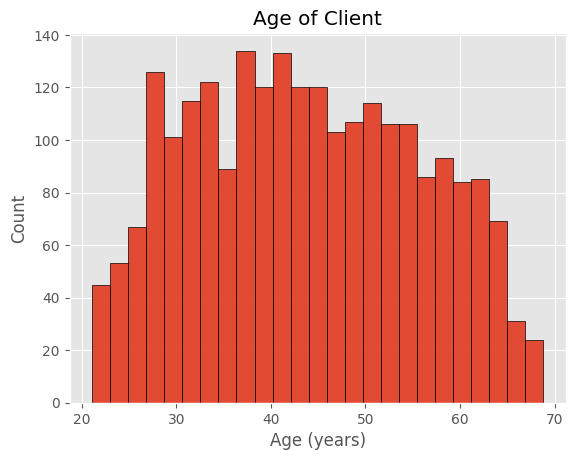

In [271]:
# Set the style of plots for using in presentation and then thesis
#plt.style.use('dark_background')
plt.style.use('ggplot')
# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

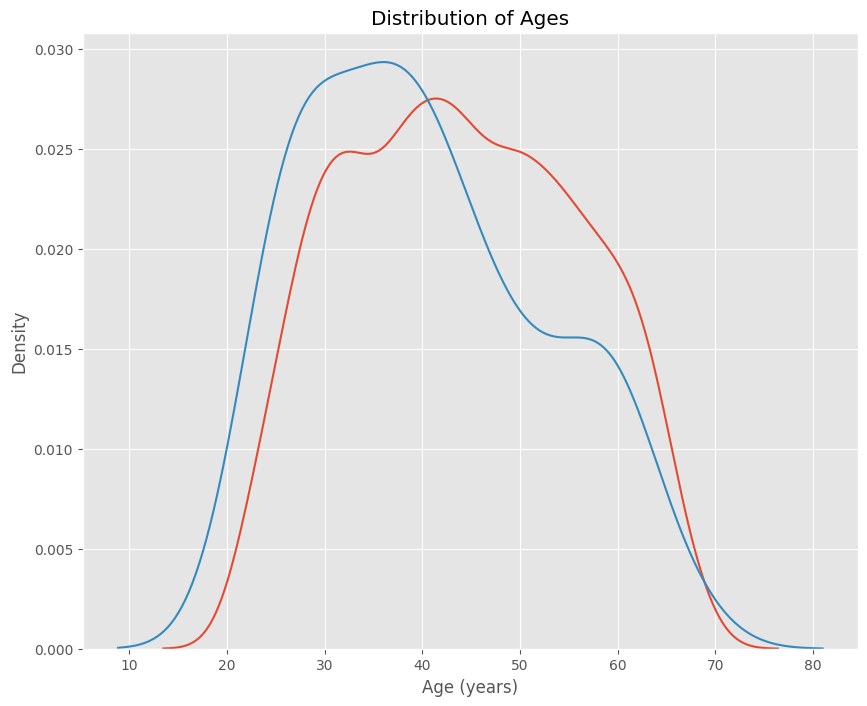

In [272]:
plt.figure(figsize = (10, 8))
# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')
# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')
# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [273]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [274]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.155340,8488.679612,23.256656
"(25.0, 30.0]",0.098039,10125.266667,27.740457
"(30.0, 35.0]",0.077703,11846.902027,32.457266
"(35.0, 40.0]",0.091205,13725.501629,37.604114
"(40.0, 45.0]",0.063830,15504.474164,42.478011
"(45.0, 50.0]",0.048951,17341.454545,47.510834
"(50.0, 55.0]",0.047273,19130.883636,52.413380
"(55.0, 60.0]",0.067729,20977.784861,57.473383
"(60.0, 65.0]",0.045226,22769.391960,62.381896


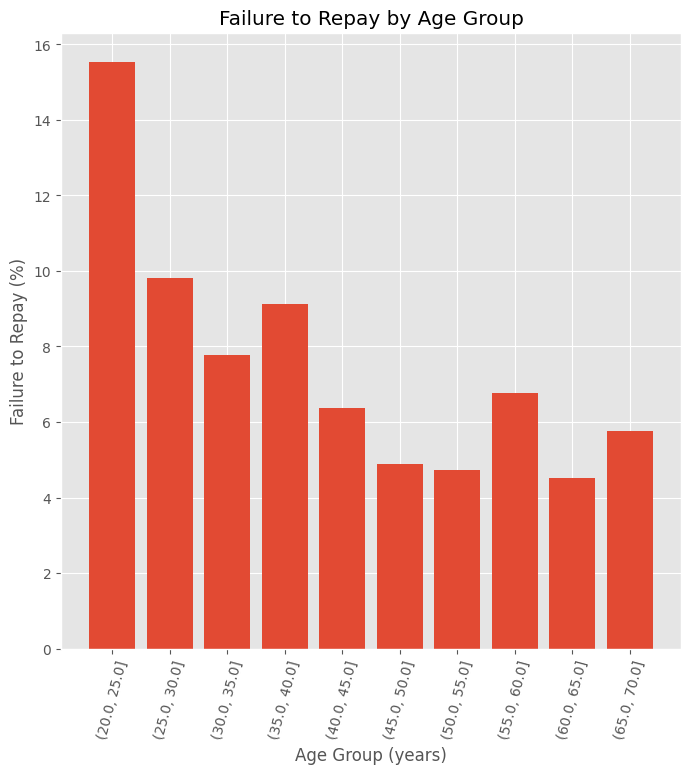

In [275]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');
#plt.savefig("output-1.jpg")
plt.savefig("output-2", bbox_inches="tight",
            pad_inches=0.3, transparent=True)

Younger people are more prone to not paying back their loans! The repayment failure rate is over 10% for the three youngest age groups, but it's less than 5% for the oldest age group.

Since younger customers are less likely to repay loans, maybe they should get extra help or financial advice. It doesn't mean the bank should treat younger customers unfairly, but being cautious and offering support could help them pay on time.

### Exterior Sources


In [276]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.140574,-0.192439,-0.239997,-0.080538
EXT_SOURCE_1,-0.140574,1.000000,0.220399,0.163321,0.624234
EXT_SOURCE_2,-0.192439,0.220399,1.000000,0.112426,0.092722
EXT_SOURCE_3,-0.239997,0.163321,0.112426,1.000000,0.217271
DAYS_BIRTH,-0.080538,0.624234,0.092722,0.217271,1.000000


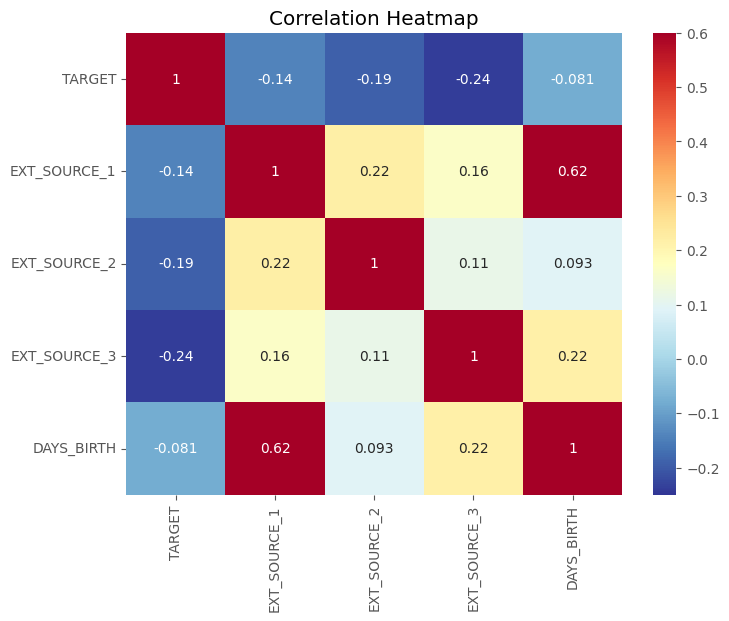

In [277]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');
plt.savefig("output-3", bbox_inches="tight",
            pad_inches=0.3, transparent=True)

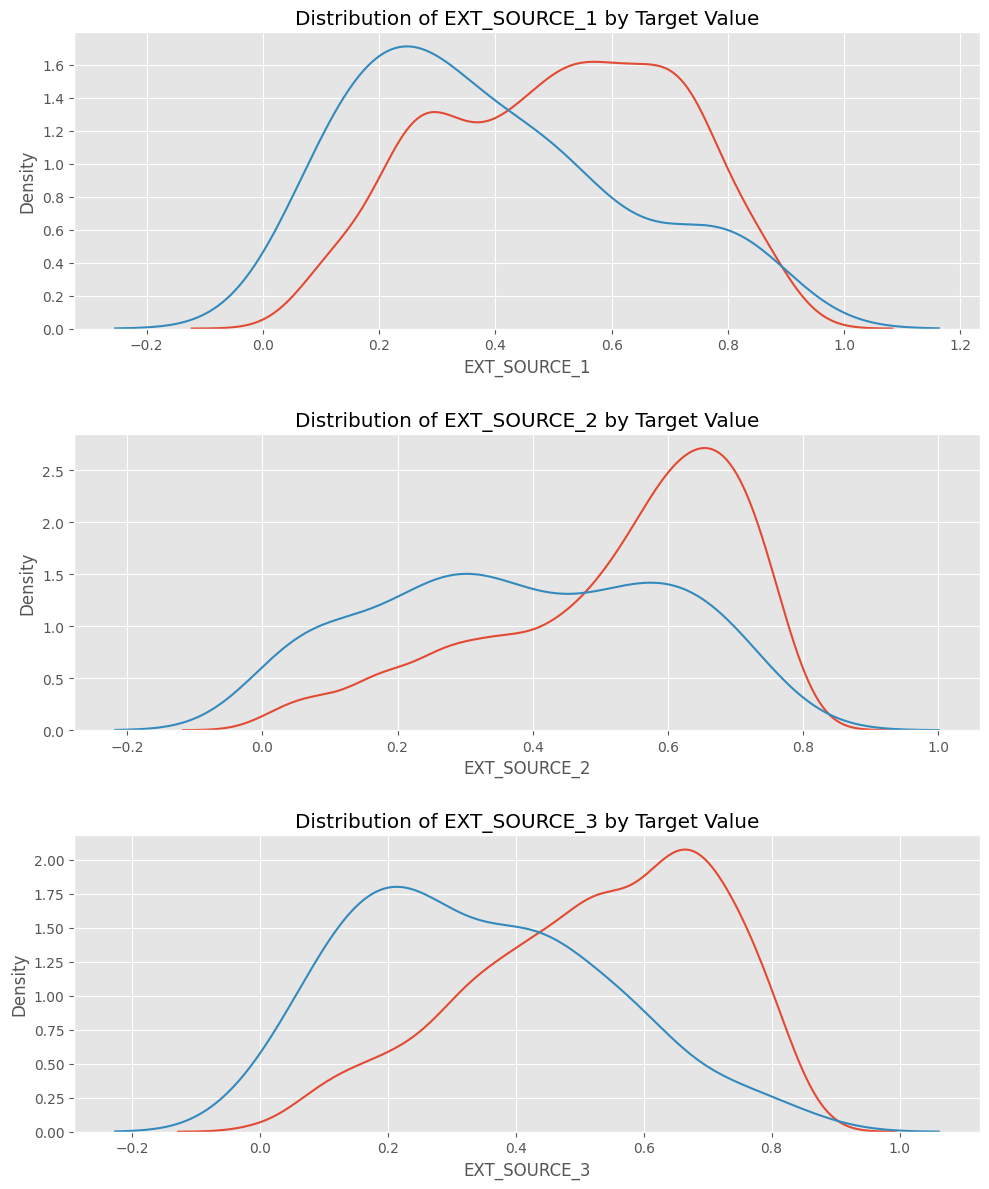

In [278]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):

    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');

plt.tight_layout(h_pad = 2.5)


## Pairs Plot

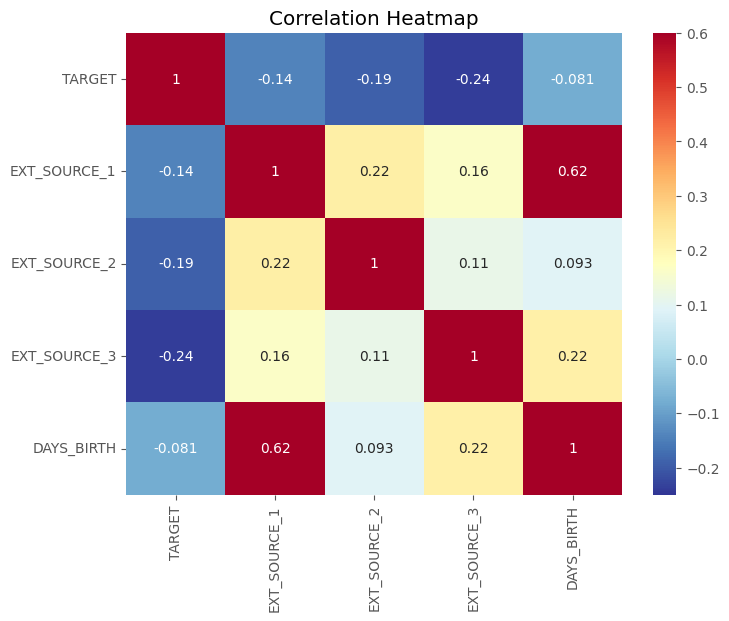

In [279]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');
plt.savefig("output-3", bbox_inches="tight",
            pad_inches=0.3, transparent=True)

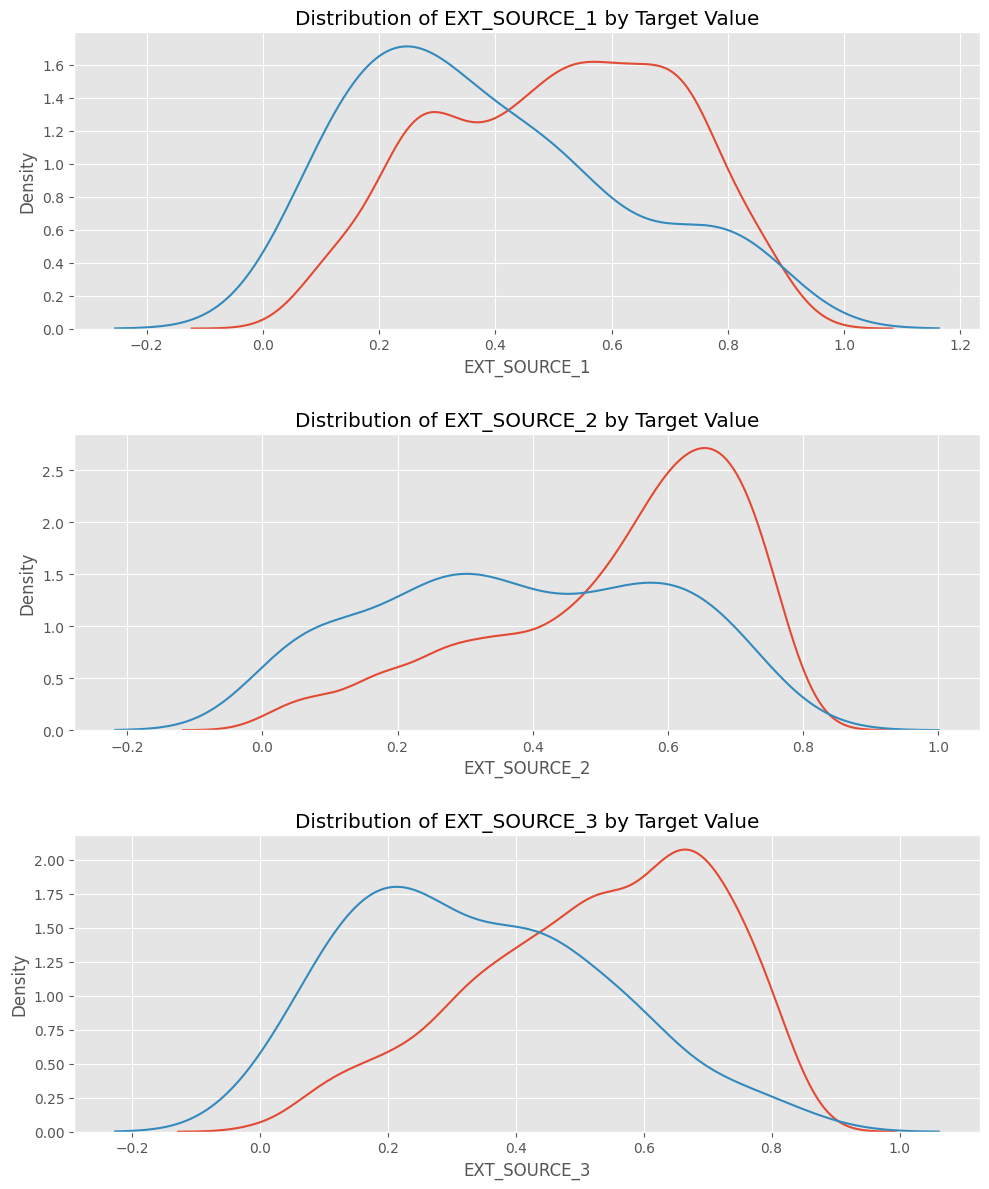

In [280]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):

    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');

plt.tight_layout(h_pad = 2.5)


## Pairs Plot

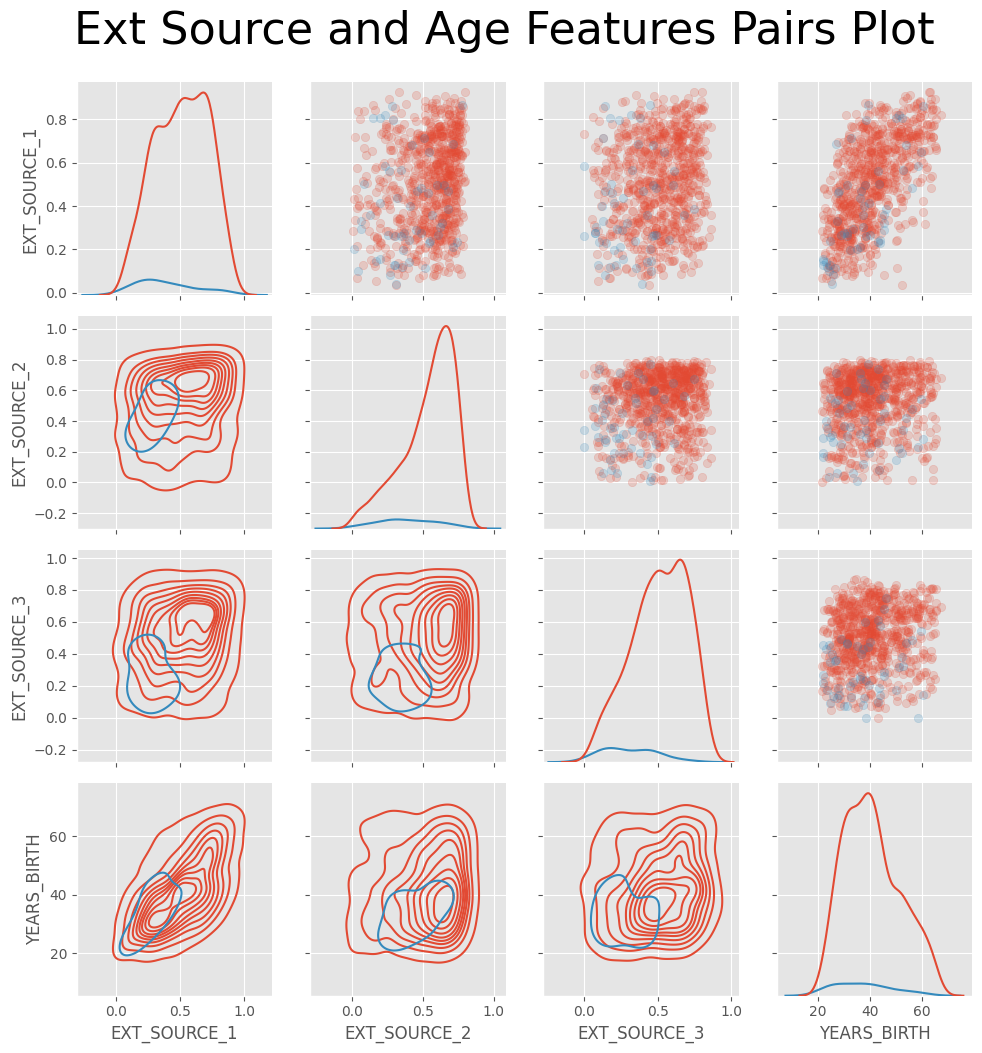

In [281]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, diag_sharey=False,
                    hue = 'TARGET',
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);
plt.savefig("output-4", bbox_inches="tight",
            pad_inches=0.3, transparent=True)


# Feature Engineering


## Polynomial Features

In [282]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

# imputer for handling missing values
#from sklearn.preprocessing import Imputer
#imputer = Imputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures

# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [283]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (2353, 35)


In [284]:
poly_transformer.get_feature_names_out(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

array(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2'], dtype=object)

In [285]:
# Create a dataframe of the features
poly_features = pd.DataFrame(poly_features,
                             columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2',
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.237889
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.218619
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.210271
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.210074
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.209354
EXT_SOURCE_3                             -0.207410
EXT_SOURCE_1 EXT_SOURCE_3                -0.193030
EXT_SOURCE_2                             -0.192603
EXT_SOURCE_3^2                           -0.185170
EXT_SOURCE_1 EXT_SOURCE_2                -0.184392
Name: TARGET, dtype: float64
DAYS_BIRTH^2     -0.074422
DAYS_BIRTH^3     -0.068121
EXT_SOURCE_1^3   -0.063131
TARGET            1.000000
1                      NaN
Name: TARGET, dtype: float64


In [286]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test,
                                  columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2',
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (2353, 263)
Testing data with polynomial features shape:   (2352, 263)


## Domain Knowledge Features

In [287]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [288]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

####  New Variables

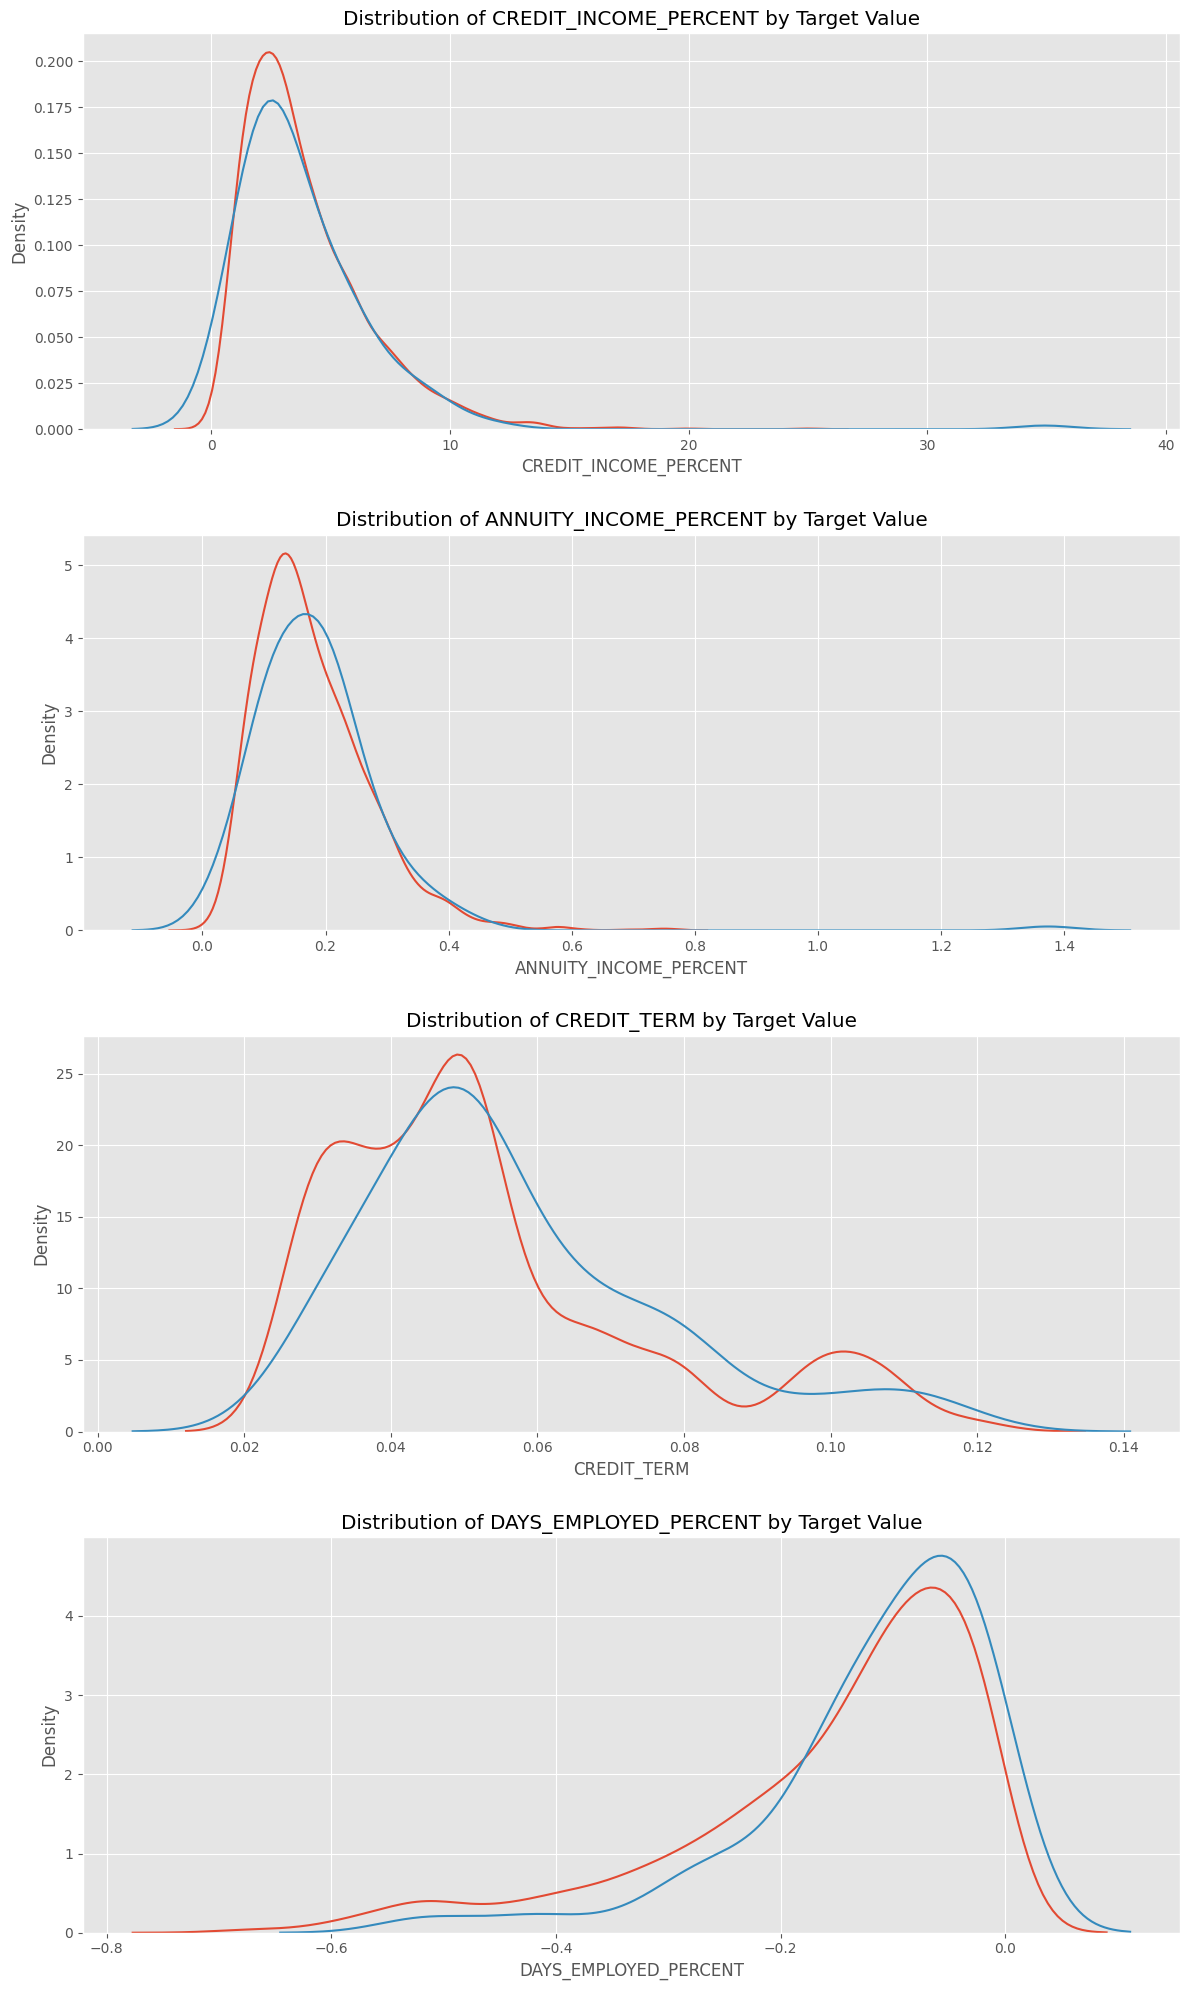

In [289]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):

    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');

plt.tight_layout(h_pad = 2.5)

# Baseline

AUC ROC: 0.5

## Logistic Regression Implementation

In [290]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import numpy as np

from sklearn.model_selection import train_test_split



# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()

# Feature names
features = list(train.columns)

# Copy of the testing data
test = app_test.copy()

# Median imputation of missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(app_test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)



X = app_train.drop('TARGET',axis=1)
#print(type(app_train))
#print(type(X))
y = app_train['TARGET']
X_imputed_array = imputer.fit_transform(X)
X= pd.DataFrame(data=X_imputed_array, columns=X.columns)
#print(type(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)
imputer.fit(X)
#print(type(X))


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

Training data shape:  (2353, 228)
Testing data shape:  (2352, 228)


In [291]:
from sklearn.linear_model import LogisticRegressionCV
# Make the model with the specified regularization parameter
log_model = LogisticRegressionCV()

# Train on the training data
log_model.fit(scaled_X_train,y_train)


LogisticRegressionCV()

In [292]:
log_model.C_
log_model.get_params()
print(log_model.coef_.shape)
#print(train.shape)
#print(train_labels.shape)

(1, 228)


In [293]:
# Make predictions
# Make sure to select the second column only
log_reg_pred = log_model.predict_proba(test)[:, 1]


In [294]:
# Submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

,SK_ID_CURR,TARGET
0,100001,0.072739
1,100005,0.074635
2,100013,0.072613
3,100028,0.073406
4,100038,0.074522


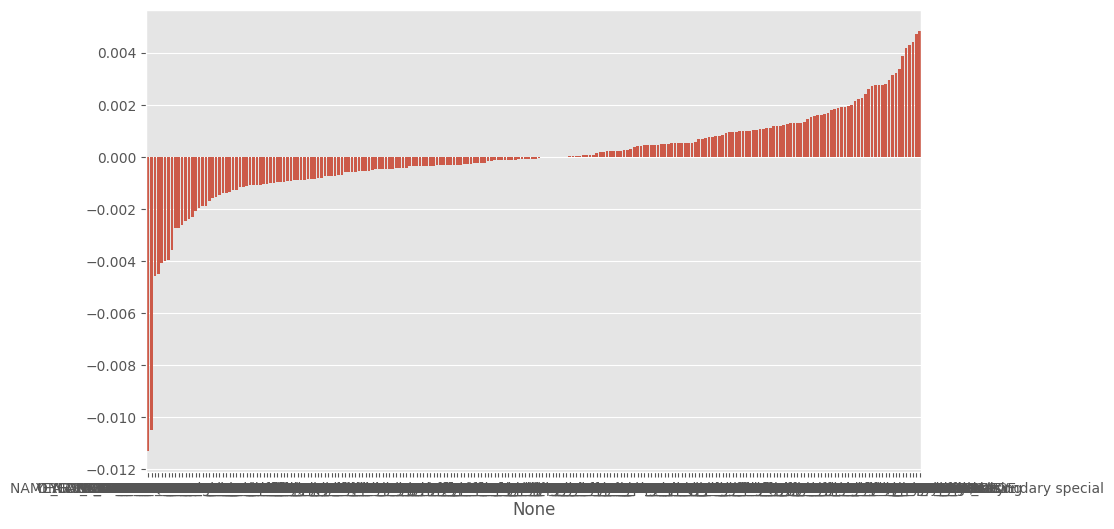

In [295]:

coefs = pd.Series(index=X.columns, data=log_model.coef_[0])
coefs = coefs.sort_values()
plt.figure(figsize=(10, 6))
sns.barplot(x=coefs.index, y=coefs.values);

In [296]:
# Save the submission to a csv file
submit.to_csv('log_reg_baseline.csv', index = False)

### LR Evaluation

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       223
           1       0.00      0.00      0.00        13

    accuracy                           0.94       236
   macro avg       0.47      0.50      0.49       236
weighted avg       0.89      0.94      0.92       236



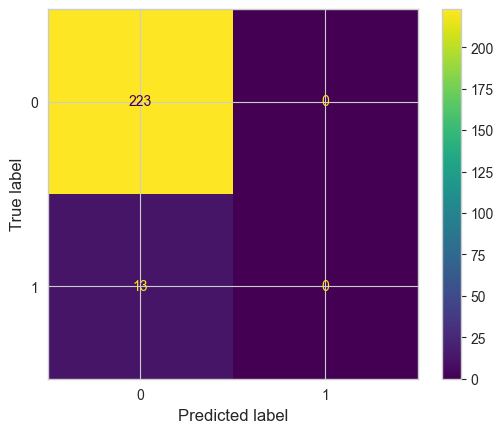

In [299]:
from sklearn.metrics import confusion_matrix,classification_report, ConfusionMatrixDisplay
y_pred = log_model.predict(scaled_X_test)
cm=confusion_matrix(y_test,y_pred)
cm
#plot_confusion_matrix(log_model,test,y_test)
print(classification_report(y_test,y_pred))
disp= ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=log_model.classes_)
disp.plot()
plt.show()

In [298]:
from sklearn.metrics import plot_precision_recall_curve,plot_roc_curve
plot_precision_recall_curve(log_model,scaled_X_test,y_test)
plot_roc_curve(log_model,scaled_X_test,y_test)

ImportError: cannot import name 'plot_precision_recall_curve' from 'sklearn.metrics' (/Users/radimbadr/miniconda3/envs/thesis-project/lib/python3.10/site-packages/sklearn/metrics/__init__.py)

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

y_probs = log_model.predict_proba(scaled_X_test)[:, 1]

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)

# Compute area under the curve (AUC) for precision-recall curve
precision_recall_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {precision_recall_auc:.2f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [ ]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_probs)

# Compute area under the curve (AUC) for ROC curve
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

# Compute ROC AUC
roc_auc_log = roc_auc_score(y_test, log_model.predict_proba(scaled_X_test)[:, 1])
print(f"ROC AUC: {roc_auc_log:.2f}")

## Single Decision tree


In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=6)
dt.fit(X_train, y_train)
pred_dt = dt.predict(X_test)


              precision    recall  f1-score   support

           0       0.94      0.99      0.96       223
           1       0.00      0.00      0.00        13

    accuracy                           0.93       236
   macro avg       0.47      0.49      0.48       236
weighted avg       0.89      0.93      0.91       236



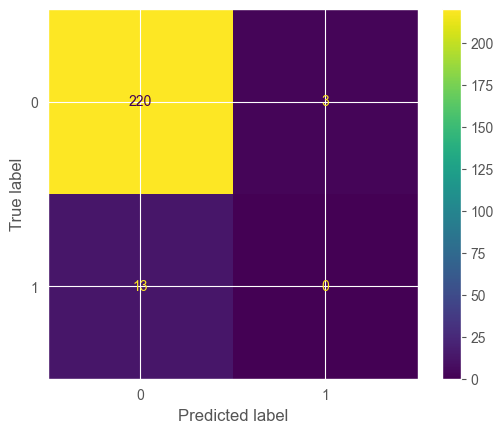

In [300]:
from sklearn.metrics import confusion_matrix,classification_report, ConfusionMatrixDisplay
cm_dt=confusion_matrix(y_test,pred_dt)
#print(cm_dt)
plt.style.use('ggplot')
#plot_confusion_matrix(log_model,test,y_test)
print(classification_report(y_test,pred_dt))
disp2= ConfusionMatrixDisplay(confusion_matrix=cm_dt,display_labels=dt.classes_)


disp2.plot()
plt.show()

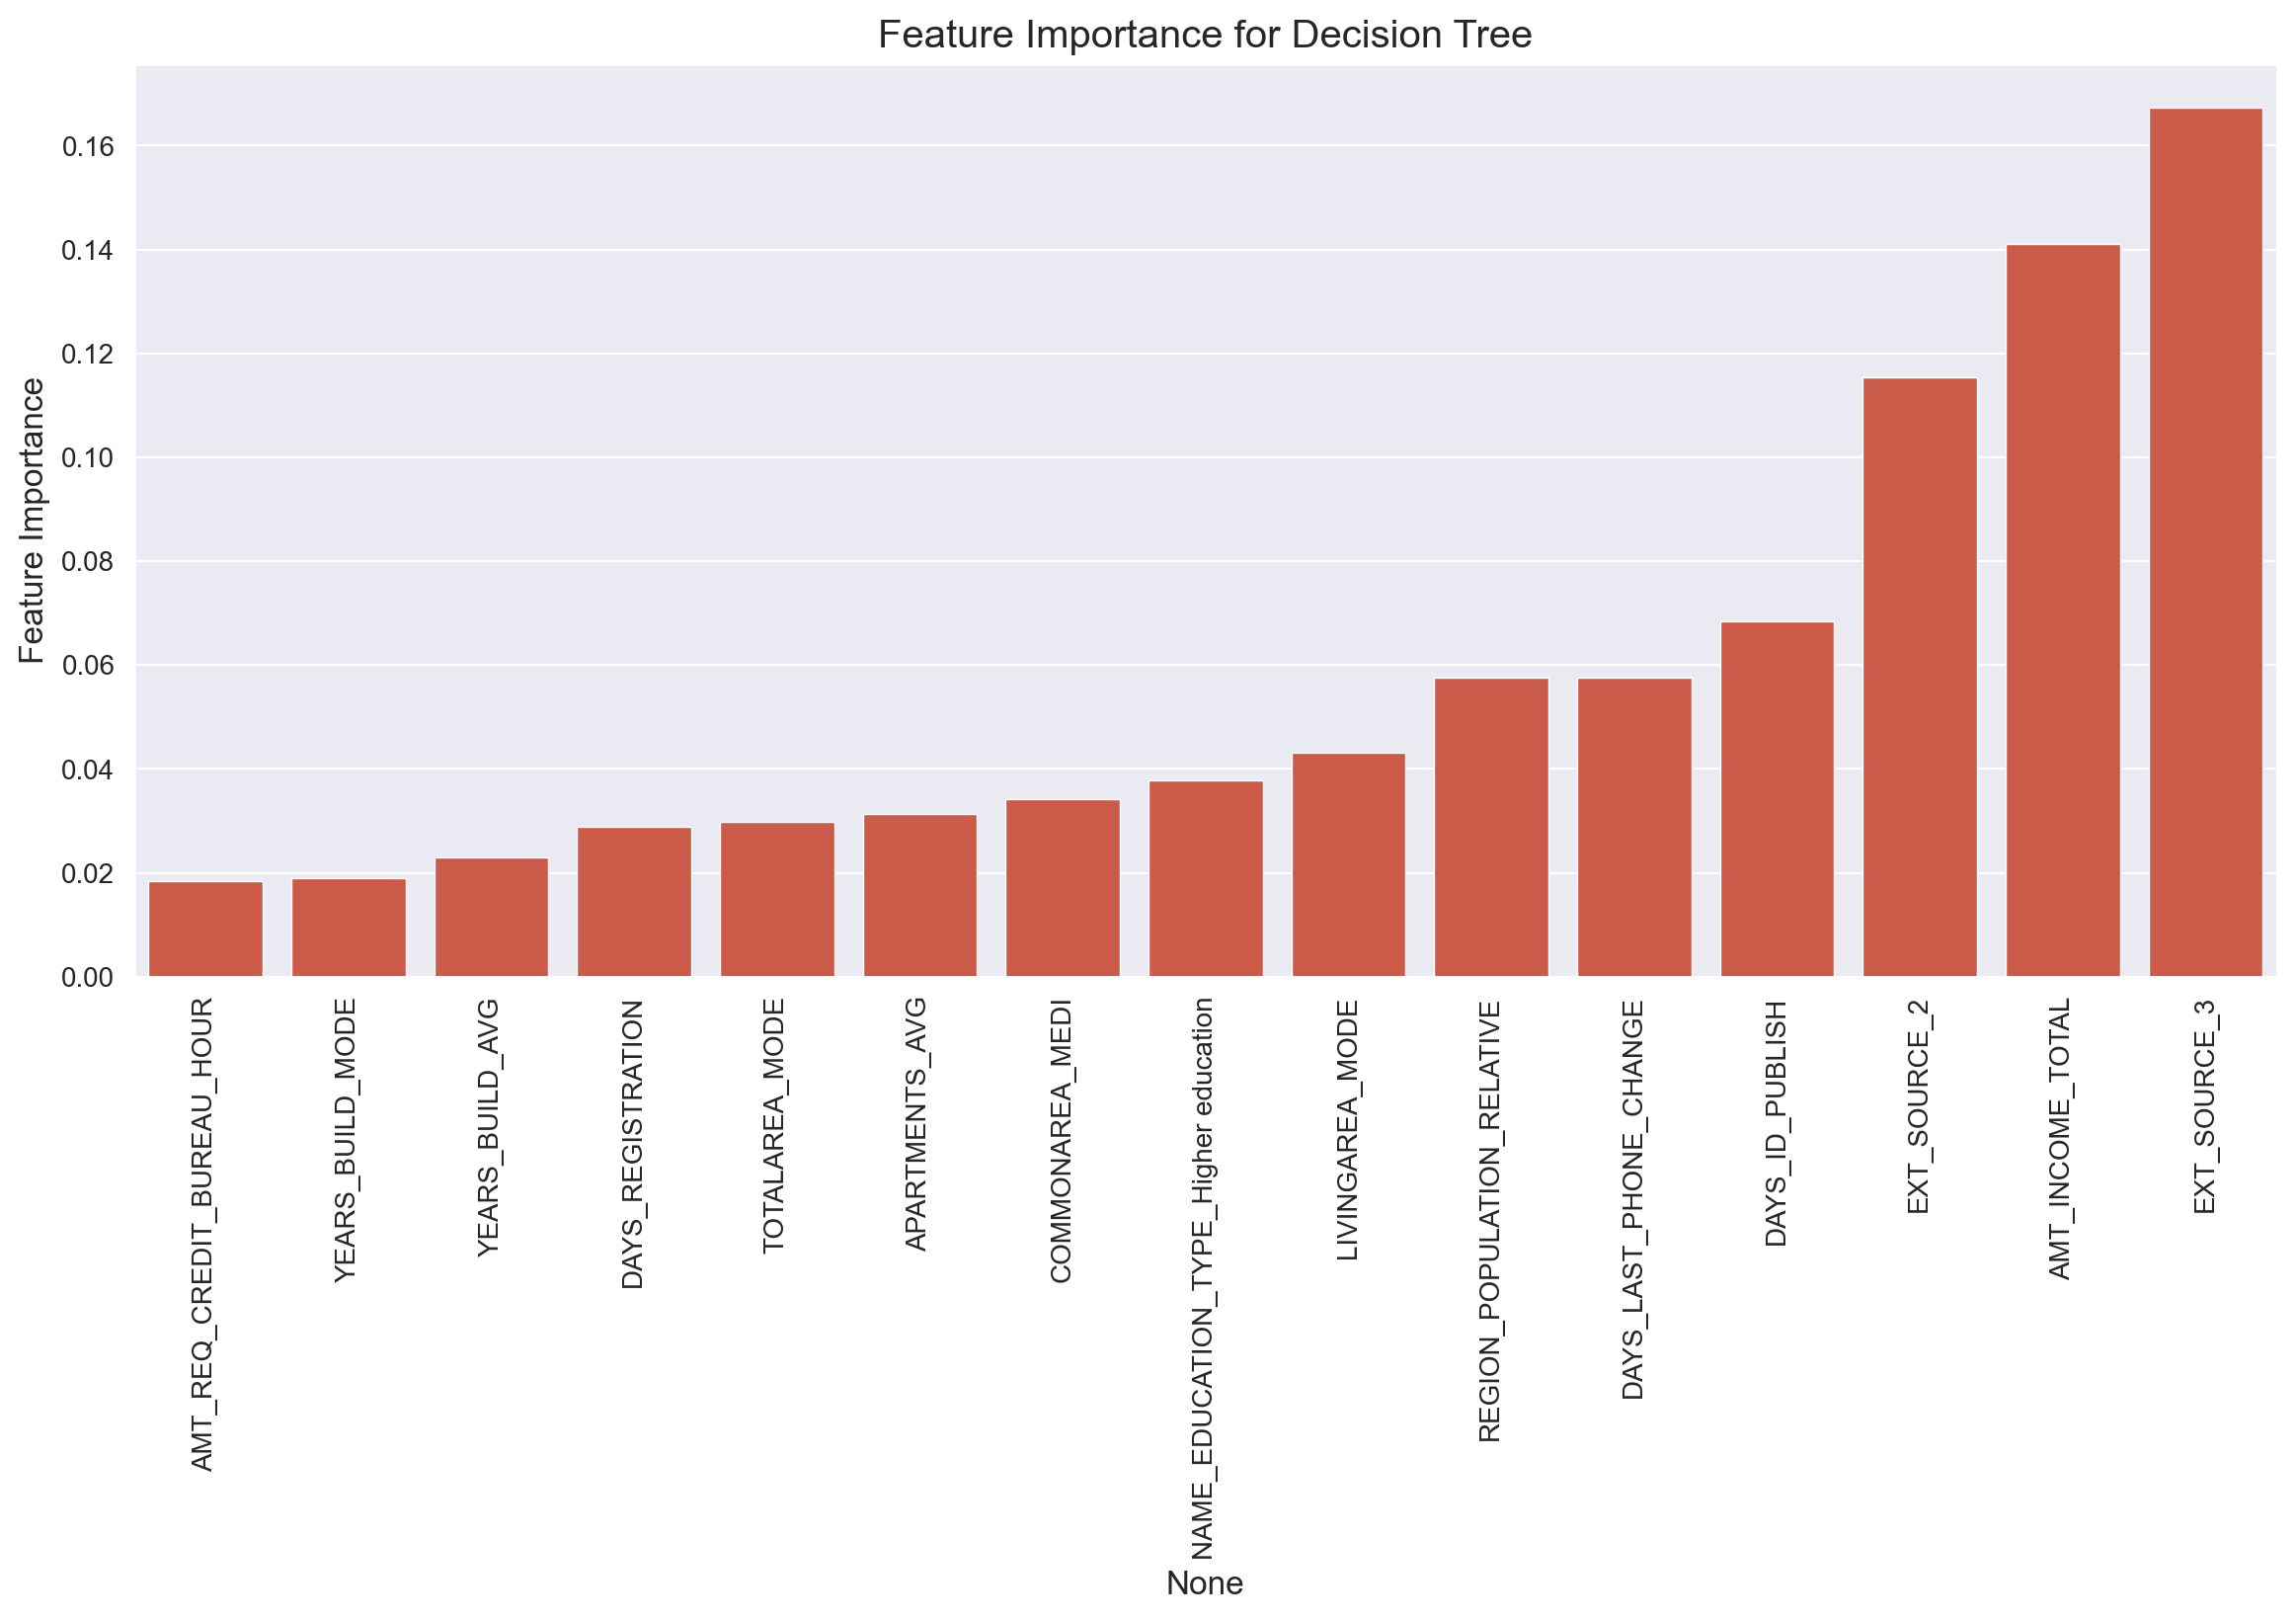

In [305]:
imp_feats = pd.DataFrame(data=dt.feature_importances_, index=X.columns, columns=['Feature Importance']).sort_values(
    "Feature Importance")
selected_features = imp_feats.tail(25)
plt.figure(figsize=(14, 6), dpi=200)
sns.barplot(data=selected_features.sort_values('Feature Importance'), x=selected_features.sort_values('Feature Importance').index,
            y='Feature Importance')
plt.xticks(rotation=90)
plt.title("Feature Importance for Decision Tree");

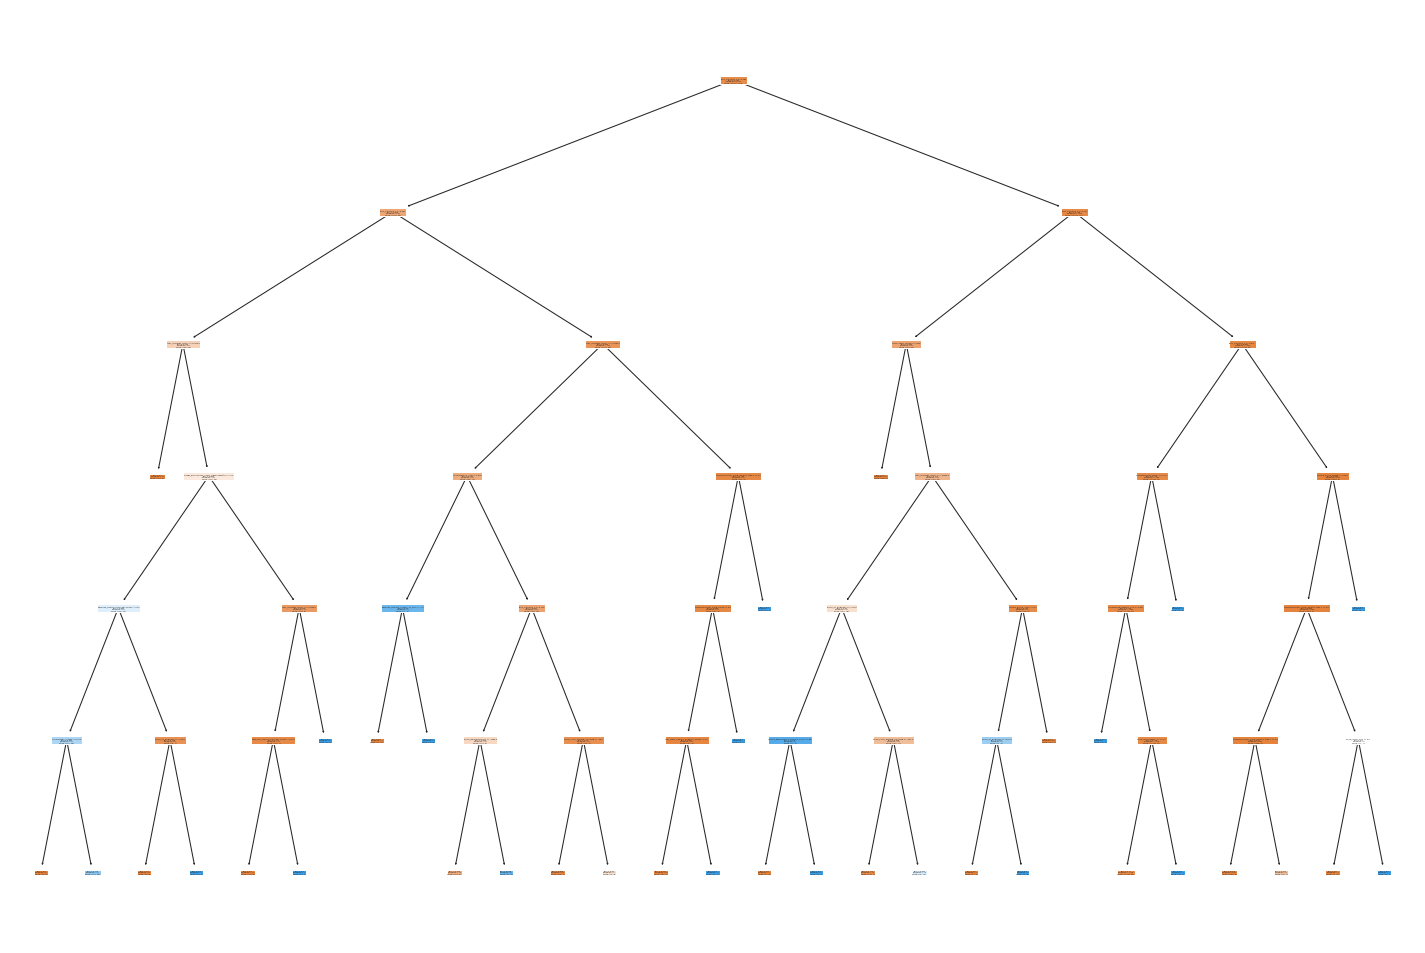

In [302]:
from sklearn.tree import plot_tree

plt.figure(figsize=(12, 8), dpi=150)
plot_tree(dt, filled=True, feature_names=X.columns);

## Random Forest
100 trees

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [ ]:
# Train on the training data
random_forest.fit(train, train_labels)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict_proba(test)[:, 1]

In [ ]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline.csv', index = False)

### Predictions using Engineered Features

In [ ]:
poly_features_names = list(app_train_poly.columns)

# Impute the polynomial features
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

poly_features = imputer.fit_transform(app_train_poly)
poly_features_test = imputer.transform(app_test_poly)

# Scale the polynomial features
scaler = MinMaxScaler(feature_range = (0, 1))

poly_features = scaler.fit_transform(poly_features)
poly_features_test = scaler.transform(poly_features_test)

random_forest_poly = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [ ]:
# Train on the training data
random_forest_poly.fit(poly_features, train_labels)

# Make predictions on the test data
predictions = random_forest_poly.predict_proba(poly_features_test)[:, 1]

In [ ]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline_engineered.csv', index = False)

#### Testing Domain Features

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

def model(features, test_features, encoding = 'ohe', n_folds = 5):

    """Train and test a light gradient boosting model using
    cross validation.

    Parameters
    --------
        features (pd.DataFrame):
            dataframe of training features to use
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame):
            dataframe of testing features to use
            for making predictions with the model.
        encoding (str, default = 'ohe'):
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation

    Return
    --------
        submission (pd.DataFrame):
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame):
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame):
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.

    """

    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']

    # Extract the labels for training
    labels = features['TARGET']

    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])


    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)

        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)

        # No categorical indices to record
        cat_indices = 'auto'

    # Integer label encoding
    elif encoding == 'le':

        # Create a label encoder
        label_encoder = LabelEncoder()

        # List for storing categorical indices
        cat_indices = []

        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)

    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")

    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)

    # Extract feature names
    feature_names = list(features.columns)

    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)

    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)

    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))

    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])

    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])

    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []

    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):

        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]

        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary',
                                   class_weight = 'balanced', learning_rate = 0.05,
                                   reg_alpha = 0.1, reg_lambda = 0.1,
                                   subsample = 0.8, n_jobs = -1, random_state = 50)

        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)

        # Record the best iteration
        best_iteration = model.best_iteration_

        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits

        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits

        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]

        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']

        valid_scores.append(valid_score)
        train_scores.append(train_score)

        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()

    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})

    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)

    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))

    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')

    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores})

    return submission, feature_importances, metrics

In [ ]:
app_train_domain = app_train_domain.drop(columns = 'TARGET')

domain_features_names = list(app_train_domain.columns)

# Impute the domainnomial features
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

domain_features = imputer.fit_transform(app_train_domain)
domain_features_test = imputer.transform(app_test_domain)

# Scale the domainnomial features
scaler = MinMaxScaler(feature_range = (0, 1))

domain_features = scaler.fit_transform(domain_features)
domain_features_test = scaler.transform(domain_features_test)

random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

# Train on the training data
random_forest_domain.fit(domain_features, train_labels)

# Extract feature importances
feature_importance_values_domain = random_forest_domain.feature_importances_
feature_importances_domain = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_values_domain})

# Make predictions on the test data
predictions = random_forest_domain.predict_proba(domain_features_test)[:, 1]

In [ ]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline_domain.csv', index = False)

## Model Interpretation: Feature Importances

As a simple method to see which variables are the most relevant, we can look at the feature importances of the random forest. Given the correlations we saw in the exploratory data analysis, we should expect that the most important features are the `EXT_SOURCE` and the `DAYS_BIRTH`. We may use these feature importances as a method of dimensionality reduction in future work.

In [ ]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better.

    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance

    Returns:
        shows a plot of the 15 most importance features

        df (dataframe): feature importances sorted by importance (highest to lowest)
        with a column for normalized importance
        """

    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()

    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()

    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))),
            df['importance_normalized'].head(15),
            align = 'center', edgecolor = 'k')

    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))

    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()

    return df

In [ ]:
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

As expected, the most important features are those dealing with `EXT_SOURCE` and `DAYS_BIRTH`. We see that there are only a handful of features with a significant importance to the model, which suggests we may be able to drop many of the features without a decrease in performance (and we may even see an increase in performance.) Feature importances are not the most sophisticated method to interpret a model or perform dimensionality reduction, but they let us start to understand what factors our model takes into account when it makes predictions.

In [ ]:
feature_importances_domain_sorted = plot_feature_importances(feature_importances_domain)

We see that all four of our hand-engineered features made it into the top 15 most important! This should give us confidence that our domain knowledge was at least partially on track.

# Conclusions

In this notebook, we saw how to get started with a Kaggle machine learning competition. We first made sure to understand the data, our task, and the metric by which our submissions will be judged. Then, we performed a fairly simple EDA to try and identify relationships, trends, or anomalies that may help our modeling. Along the way, we performed necessary preprocessing steps such as encoding categorical variables, imputing missing values, and scaling features to a range. Then, we constructed new features out of the existing data to see if doing so could help our model.

Once the data exploration, data preparation, and feature engineering was complete, we implemented a baseline model upon which we hope to improve. Then we built a second slightly more complicated model to beat our first score. We also carried out an experiment to determine the effect of adding the engineering variables.

We followed the general outline of a [machine learning project](https://towardsdatascience.com/a-complete-machine-learning-walk-through-in-python-part-one-c62152f39420):

1.  Understand the problem and the data
2. Data cleaning and formatting (this was mostly done for us)
3. Exploratory Data Analysis
4. Baseline model
5.  Improved model
6. Model interpretation (just a little)

Machine learning competitions do differ slightly from typical data science problems in that we are concerned only with achieving the best performance on a single metric and do not care about the interpretation. However, by attempting to understand how our models make decisions, we can try to improve them or examine the mistakes in order to correct the errors. In future notebooks we will look at incorporating more sources of data, building more complex models (by following the code of others), and improving our scores.

I hope this notebook was able to get you up and running in this machine learning competition and that you are now ready to go out on your own - with help from the community - and start working on some great problems!

__Running the notebook__: now that we are at the end of the notebook, you can hit the blue Commit & Run button to execute all the code at once. After the run is complete (this should take about 10 minutes), you can then access the files that were created by going to the versions tab and then the output sub-tab. The submission files can be directly submitted to the competition from this tab or they can be downloaded to a local machine and saved. The final part is to share the share the notebook: go to the settings tab and change the visibility to Public. This allows the entire world to see your work!

### Follow-up Notebooks

For those looking to keep working on this problem, I have a series of follow-up notebooks:

* [Manual Feature Engineering Part One](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering)
* [Manual Feature Engineering Part Two](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering-p2)
* [Introduction to Automated Feature Engineering](https://www.kaggle.com/willkoehrsen/automated-feature-engineering-basics)
* [Advanced Automated Feature Engineering](https://www.kaggle.com/willkoehrsen/tuning-automated-feature-engineering-exploratory)
* [Feature Selection](https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection)
* [Intro to Model Tuning: Grid and Random Search](https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search)

As always, I welcome feedback and constructive criticism. I write for Towards Data Science at https://medium.com/@williamkoehrsen/ and can be reached on Twitter at https://twitter.com/koehrsen_will

Will


# Just for Fun: Light Gradient Boosting Machine

Now (if you want, this part is entirely optional) we can step off the deep end and use a real machine learning model: the [gradient boosting machine](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/) using the [LightGBM library](http://lightgbm.readthedocs.io/en/latest/Quick-Start.html)! The Gradient Boosting Machine is currently the leading model for learning on structured datasets (especially on Kaggle) and we will probably need some form of this model to do well in the competition. Don't worry, even if this code looks intimidating, it's just a series of small steps that build up to a complete model. I added this code just to show what may be in store for this project, and because it gets us a slightly better score on the leaderboard. In future notebooks we will see how to work with more advanced models (which mostly means adapting existing code to make it work better), feature engineering, and feature selection. See you in the next notebook!

In [ ]:
submission, fi, metrics = model(app_train, app_test)
print('Baseline metrics')
print(metrics)

In [ ]:
fi_sorted = plot_feature_importances(fi)

In [ ]:
submission.to_csv('baseline_lgb.csv', index = False)

This submission should score about 0.735 on the leaderboard. We will certainly best that in future work!

In [ ]:
app_train_domain['TARGET'] = train_labels

# Test the domain knolwedge features
submission_domain, fi_domain, metrics_domain = model(app_train_domain, app_test_domain)
print('Baseline with domain knowledge features metrics')
print(metrics_domain)

In [ ]:
fi_sorted = plot_feature_importances(fi_domain)

Again, we see tha some of our features made it into the most important. Going forward, we will need to think about whatother domain knowledge features may be useful for this problem (or we should consult someone who knows more about the financial industry!

In [ ]:
submission_domain.to_csv('baseline_lgb_domain_features.csv', index = False)

This model scores about 0.754 when submitted to the public leaderboard indicating that the domain features do improve the performance! [Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) is going to be a critical part of this competition (as it is for all machine learning problems)!

## Metrics: MSE, ROC AUC, Log loss, R-squared

In [ ]:
from sklearn.metrics import mean_squared_error

# Assuming y_test and y_pred are your true and predicted values
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")

In [ ]:
from sklearn.metrics import roc_auc_score

# Compute ROC AUC
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
print(f"ROC AUC: {roc_auc:.2f}")

In [ ]:
from sklearn.metrics import log_loss

# Compute Log Loss
logloss = log_loss(y_test, model.predict_proba(X_test_scaled))
print(f"Log Loss: {logloss:.2f}")

In [ ]:
from sklearn.metrics import r2_score

# Assuming y_test and y_pred are your true and predicted values
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R²): {r2:.2f}")